In [3]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
warnings.filterwarnings("ignore")
df = pd.read_csv("../input/iyzico-data/iyzico_data.csv")

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
check_df(df)

##################### Shape #####################
(7667, 5)
##################### Types #####################
Unnamed: 0             int64
transaction_date      object
merchant_id            int64
Total_Transaction      int64
Total_Paid           float64
dtype: object
##################### Head #####################
   Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
0           0       2018-01-01          535                349   25883.226
1           1       2018-01-01        42616                141   40918.860
2           2       2018-01-01        46774                410  306902.700
3           3       2018-01-01        86302                 10      11.340
4           4       2018-01-01       124381                285  111383.766
##################### Tail #####################
      Unnamed: 0 transaction_date  merchant_id  Total_Transaction   Total_Paid
7662        7662       2020-12-31        46774               3394  3174751.332
7663        7663       20

In [6]:
df.head()
#transaction_date =  Satış verilerinin tarihi
#merchant_id  = Üye iş yerlerinin id'leri (Her bir Üye iş yeri için eşsiz numara)
#Total_Transaction  = İşlem sayısı
#Total_Paid  = Ödeme miktarı

,Unnamed: 0,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,0,2018-01-01,535,349,25883.226
1,1,2018-01-01,42616,141,40918.860
2,2,2018-01-01,46774,410,306902.700
3,3,2018-01-01,86302,10,11.340
4,4,2018-01-01,124381,285,111383.766


In [7]:
df["transaction_date"] = df["transaction_date"].apply(pd.to_datetime)

In [8]:
df["transaction_date"].min(), df["transaction_date"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [15]:
df.shape

(7667, 5)

In [16]:
#Her üye iş yerindeki toplam işlem sayısı 
df.groupby("merchant_id").agg({"Total_Transaction":["sum"]})

,Total_Transaction
,sum
merchant_id,
535,1302725
42616,1126191
46774,1599559
57192,1146440
86302,840951
124381,1935357
129316,440029


In [17]:
#Her üye iş yerindeki toplam ödeme miktarı 
df.groupby("merchant_id").agg({"Total_Paid":["sum"]})

,Total_Paid
,sum
merchant_id,
535,1.566015e+08
42616,3.545831e+08
46774,1.567200e+09
57192,3.173371e+08
86302,2.870447e+06
124381,1.158693e+09
129316,1.555471e+06


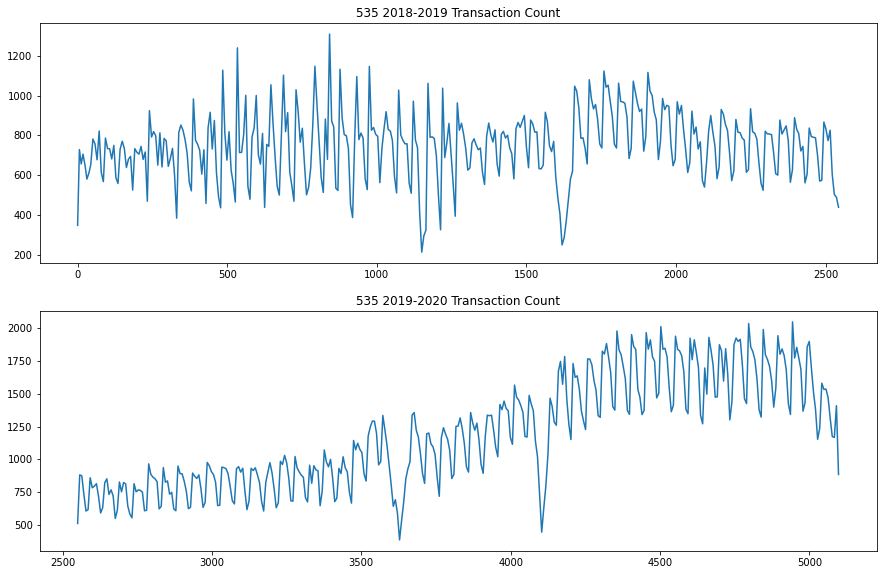

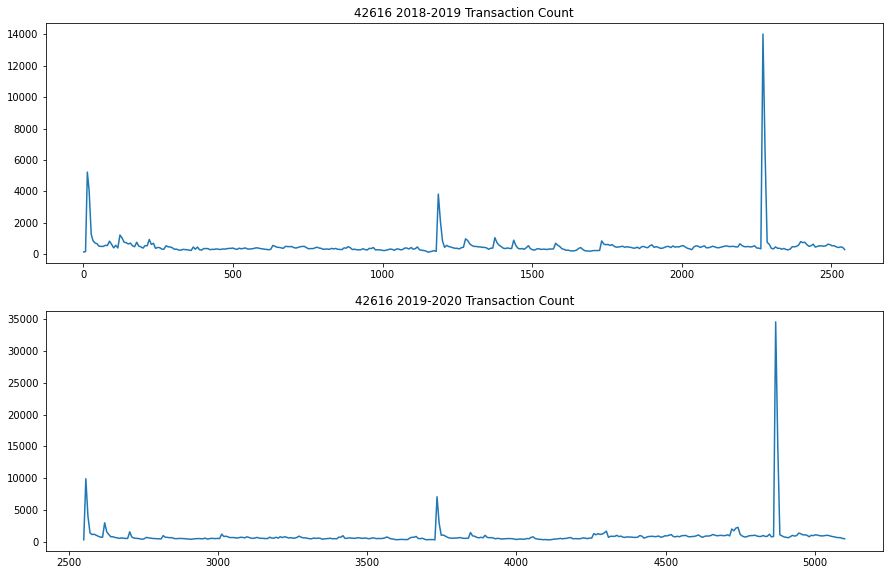

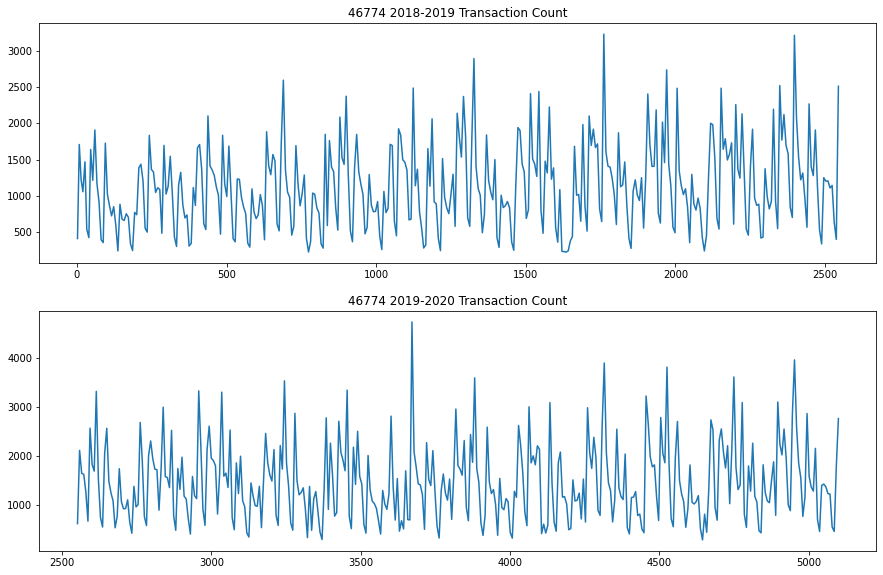

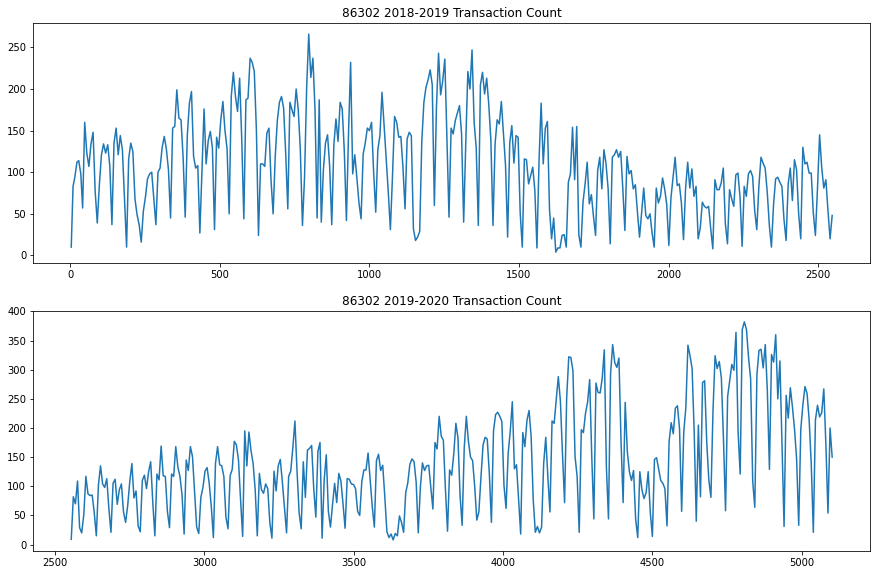

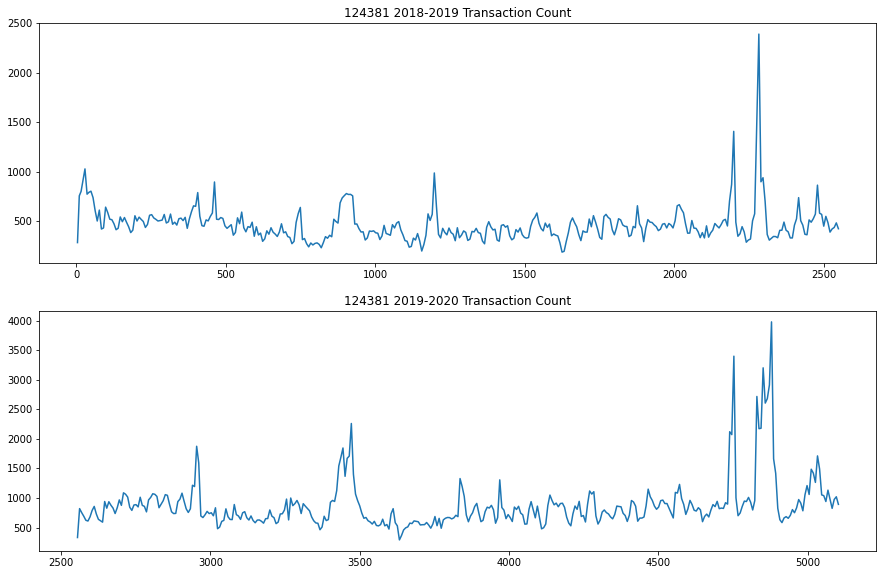

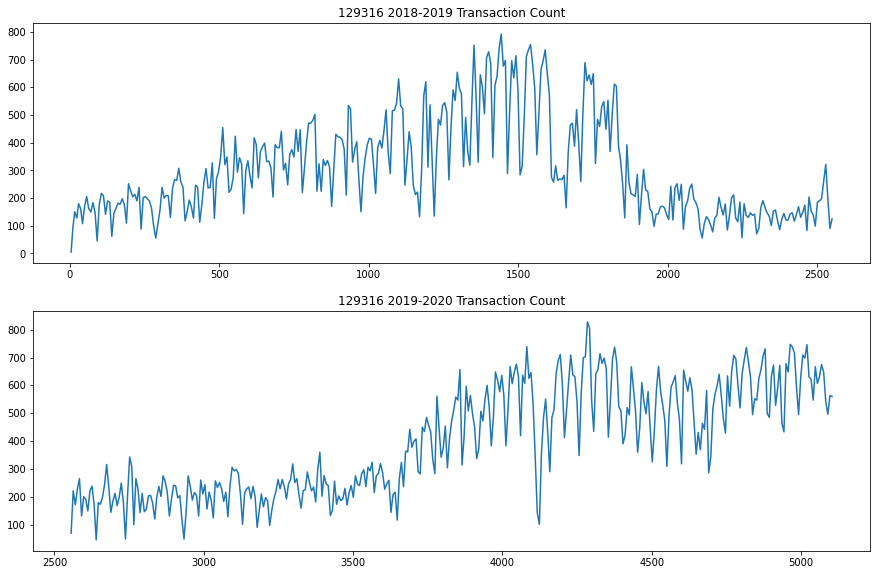

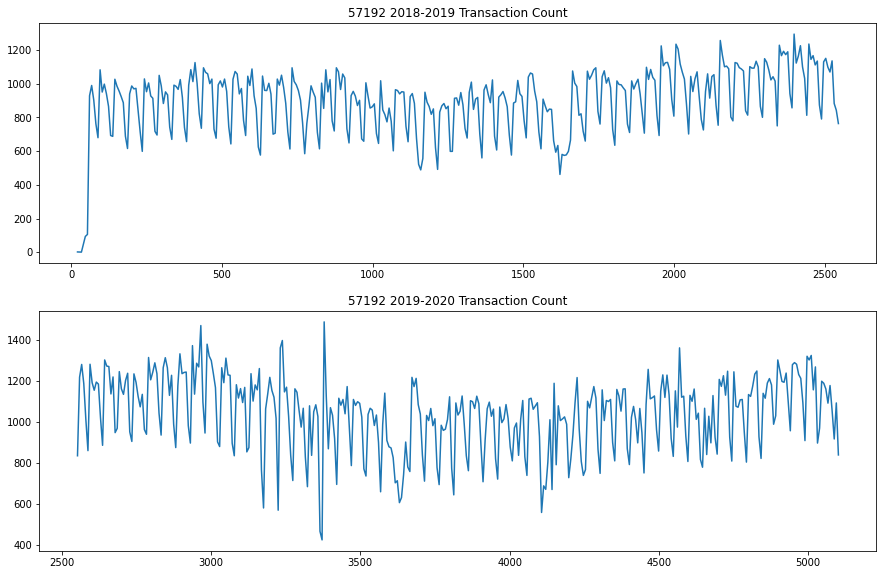

In [21]:
#Her üye iş yerininin her bir yıl içerisindeki transaction count grafikleri

for id in df.merchant_id.unique():
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, 1, title = str(id) + ' 2018-2019 Transaction Count')
    df[(df.merchant_id == id) &( df.transaction_date >= "2018-01-01" )& (df.transaction_date < "2019-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.subplot(3, 1, 2,title = str(id) + ' 2019-2020 Transaction Count')
    df[(df.merchant_id == id) &( df.transaction_date >= "2019-01-01" )& (df.transaction_date < "2020-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.show()


In [22]:
# Feature Engineering
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df = create_date_features(df, "transaction_date")
df.head()


,Unnamed: 0,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [23]:
# Üye iş yerinin yıl, ay ve gün bazında işlem sayılarının incelenmesi
df.groupby(["merchant_id","year","month","day_of_month"]).agg({"Total_Transaction": ["sum", "mean", "median", "std",]})

Total_Transaction                  
                                                  sum   mean median std
merchant_id year month day_of_month                                    
535         2018 1     1                          349  349.0  349.0 NaN
                       2                          729  729.0  729.0 NaN
                       3                          657  657.0  657.0 NaN
                       4                          706  706.0  706.0 NaN
                       5                          648  648.0  648.0 NaN
...                                               ...    ...    ...  ..
129316      2020 12    27                         620  620.0  620.0 NaN
                       28                         640  640.0  640.0 NaN
                       29                         703  703.0  703.0 NaN
                       30                         642  642.0  642.0 NaN
                       31                         485  485.0  485.0 NaN

[7667 rows x 4 columns]

In [24]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=len(dataframe))

In [27]:
df.head()

,Unnamed: 0,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
1150,1150,2018-06-15,535,215,20579.400,6,15,166,24,4,2018,1,0,0,2,0,0,0,0
1619,1619,2018-08-21,535,251,31779.324,8,21,233,34,1,2018,0,0,0,3,0,0,0,0
1626,1626,2018-08-22,535,287,34470.216,8,22,234,34,2,2018,0,0,0,3,0,0,0,0
1157,1157,2018-06-16,535,296,34056.000,6,16,167,24,5,2018,1,0,0,2,0,0,0,0
1164,1164,2018-06-17,535,325,35188.254,6,17,168,24,6,2018,1,0,0,2,0,0,0,0


In [ ]:
##Lag/shifted Features
df.sort_values(by=["merchant_id", "Total_Transaction", "transaction_date"], axis=0, inplace=True)


In [28]:
pd.DataFrame({"Total_Transaction": df["Total_Transaction"].values[0:10],
              "lag1": df["Total_Transaction"].shift(1).values[0:10],
              "lag2": df["Total_Transaction"].shift(2).values[0:10],
              "lag3": df["Total_Transaction"].shift(3).values[0:10],
              "lag4": df["Total_Transaction"].shift(4).values[0:10]})

,Total_Transaction,lag1,lag2,lag3,lag4
0,215,NaN,NaN,NaN,NaN
1,251,215.0,NaN,NaN,NaN
2,287,251.0,215.0,NaN,NaN
3,296,287.0,251.0,215.0,NaN
4,325,296.0,287.0,251.0,215.0
5,327,325.0,296.0,287.0,251.0
6,349,327.0,325.0,296.0,287.0
7,371,349.0,327.0,325.0,296.0
8,385,371.0,349.0,327.0,325.0
9,387,385.0,371.0,349.0,327.0


In [29]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])


In [31]:
# Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])



In [33]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)


In [34]:
df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_black_friday"]=1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin(["2018-06-19","2018-06-20","2018-06-21","2018-06-22",
                                    "2019-06-19","2019-06-20","2019-06-21","2019-06-22",]) ,"is_summer_solstice"]=1




In [36]:
df = pd.get_dummies(df, columns=['merchant_id','day_of_week', 'month'])


# model Gradient descent temelli lgbm olduğu için bağımlı değişkeni standartlaştırma yaptım.
# iterasyon süresini kısaltmak için.

df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)



In [38]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


,Unnamed: 0,transaction_date,Total_Transaction,Total_Paid,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_alpha_05_lag_630,sal